In [280]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler as scaler
import os


In [281]:
# carga de datos de refencia en un data frame para su filtrado
path = 'reference_data/'
files = os.listdir(path)

dict_files = {
    'date':list(),
    'link':list()
}

for file in files:
    if '.nc' in file:
        # generacion link
        link = os.path.join(
            path,
            file
        )
        #Formateo fecha
        year = file.split('_')[2]
        month = file.split('_')[3].split('.')[0]
        date = pd.to_datetime(year + '/' + month)
        # Almacenamiento
        dict_files['date'].append(date)
        dict_files['link'].append(link)
# Creacion del dataframe
df_files_reference = pd.DataFrame(dict_files)
df_files_reference.set_index(
    'date',
    drop=True,
    inplace=True
)
df_files_reference_reference = df_files_reference.sort_index()

In [214]:
# carga de datos target para su filtrado
path = 'target_data/'
files_target = os.listdir(path)
files_target = [path+file_name for file_name in files_target]

NameError: name 'start' is not defined

In [ ]:
def get_data_by_coordenates_date_ERA(lat,long,start,end,height):
    """
    se tienen los datos de reanalisis de ERA,
    lo que se hace aquí es filtrar del data frame df_files_reference
    la locacion, temporalidad y altura de todos los datos disponibles
    
    """
    # se entregan los datos de fecha con el formato "1990-01-30"
    mask = (df_files_reference.index>=start) & (df_files_reference.index<end)
    df_filtered = df_files_reference[mask]
    
    acum = xr.open_dataset(df_filtered['link'][0]).sel(
            latitude = lat,
            longitude = long,
            method = 'nearest'

    )
    for link in df_filtered[(df_filtered.index>=start) & (df_filtered.index<end)]['link'][1:].to_numpy():
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        acum = xr.concat([acum,temporal],dim = "valid_time")
        
    df = acum.to_dataframe()
    if height == '10':
        df = np.hypot(df['u10'],df['v10'])
    elif height == '100':
        df = np.hypot(df['u100'],df['v100'])
    else:
        raise Exception('Not a valid height, type "10" or "100"')
    
    df.columns = ['wind_speed (m/s)']

    return pd.DataFrame(df).sort_index()


# conseguir datos de la carpeta de estaciones velocidad del viendo ideam
def get_data_by_coordenates_date_ideam(station,start,end):
    # se entregan los datos de fecha con el formato "1990-01-30"
    """
    se usa el file_target como el arreglo donde están los archivos disponibles para el analisis de datos
    se retorna un data frame de pandas con la información de velocidad de viento de ideam en la 
    estacion y años indicados
    """
    file_path = None
    for files_target_path in files_target:
        if station in files_target_path:
            file_path = files_target_path
            break

    if file_path == None:
        raise Exception('Información de estación no disponible')
    df = pd.read_csv(file_path,sep = '\t')
    df = df.set_index('fecha')
    df.index = pd.to_datetime(df.index)
    
    return df[(df.index>=start)&(df.index<end)].sort_index()



In [285]:
# retrieving reference data
station = '0015075501'
lat = 	12.22430556
long = -71.98288889
start_year = 2013
end_year = start_year+1
height = '10'

# se definen los dos puntos donde se va a realizar el MCP,
# se define una distancia de 50 km entre ambos datos, minima distancia disponible
df_reference = get_data_by_coordenates_date_ERA(lat, long,str(start_year),str(end_year),height)
df_target = get_data_by_coordenates_date_ideam(station,str(start_year),str(end_year)).resample('h').mean()


KeyError: 'link'

Text(0.5, 1.0, 'Reference data for MCP')

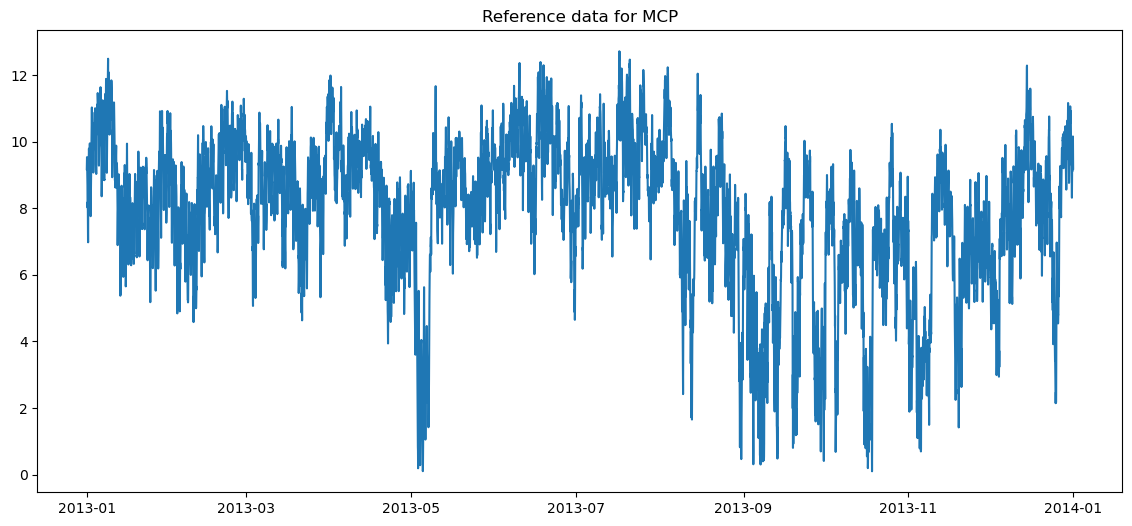

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_reference)
plt.title('Reference data for MCP')

Text(0.5, 1.0, 'Target data for MCP')

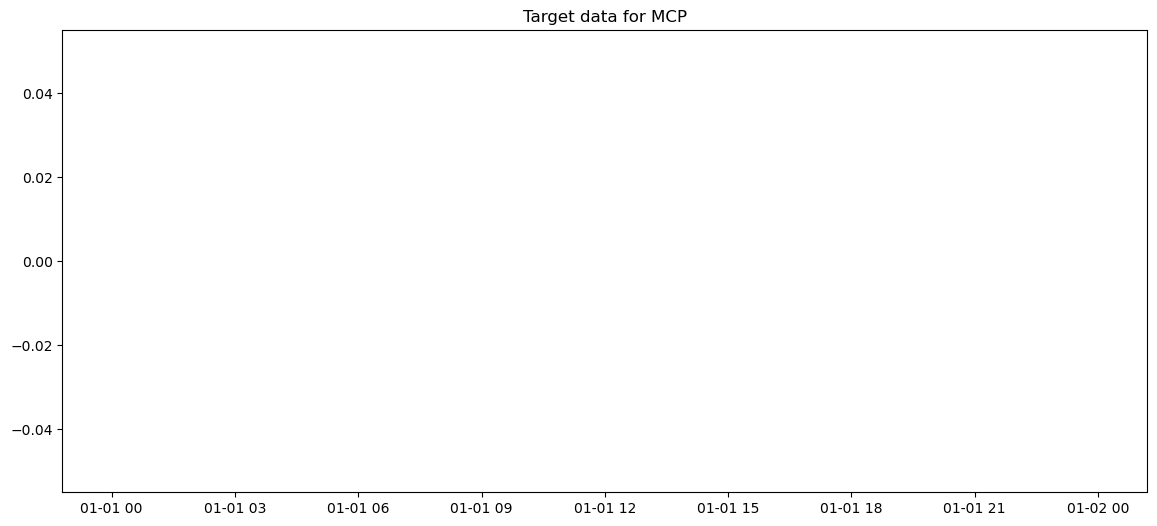

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_target)
plt.title("Target data for MCP")

In [ ]:
df_target[(df_target.index>="2016-10") &( df_target.index<="2016-12")]

,velocidad
fecha,


Text(0.5, 1.0, 'target data for MCP')

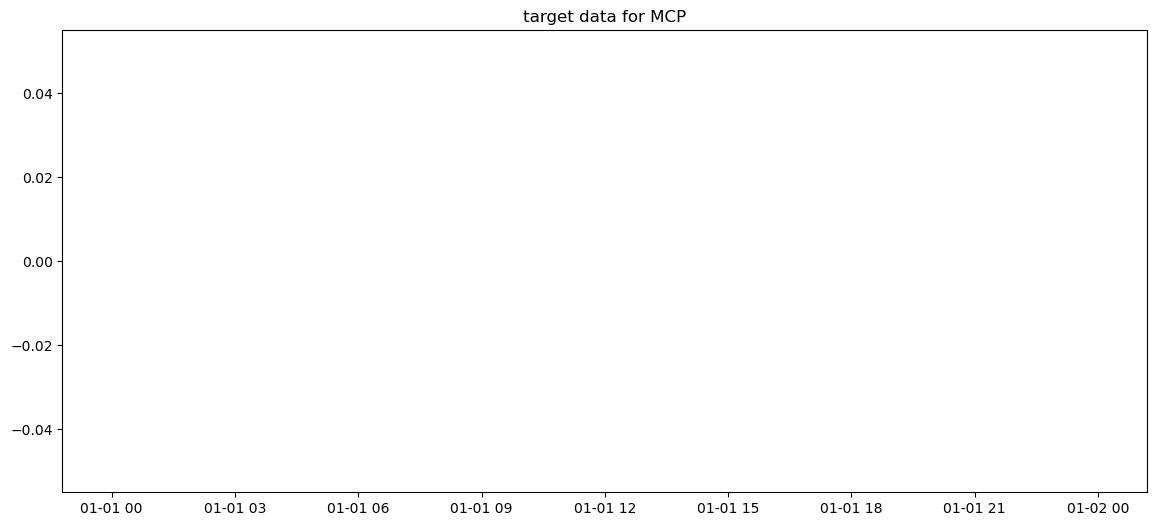

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_target)
plt.title('target data for MCP')

In [ ]:
# se convierten los datos en estructuras utiles para el entrenamiento de modelos
# además de utilizar escalarlos para tener una mejor regularizacion al
# usar Ridge y lasso

x_training = scaler().fit_transform(x_training)
y_training = scaler().fit_transform(y_training)

NameError: name 'x_training' is not defined

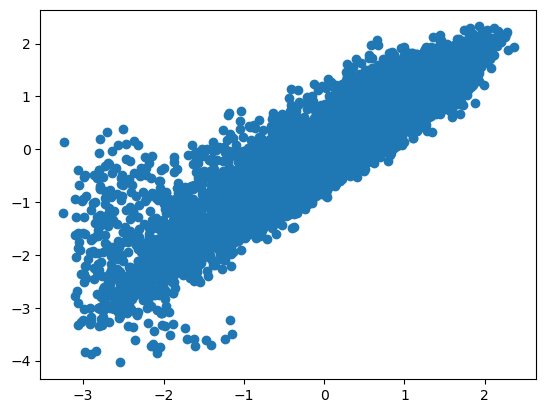

In [ ]:

plt.scatter(x_training,y_training)

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression,LassoCV

modelRidge = Ridge()
modelRidge.fit(x_training,y_training)
print("Ridge score:",modelRidge.score(x_training,y_training))

modelLinear = LinearRegression()
modelLinear.fit(x_training,y_training)
print("Linear score:",modelLinear.score(x_training,y_training))

modelLasso = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(x_training, y_training)
modelLasso.fit(x_training,y_training)
print("Lasso score:",modelLasso.score(x_training,y_training))

Ridge score: 0.810085654258728
Linear score: 0.810085654258728
Lasso score: 0.810085654258728


/home/choclo/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/choclo/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


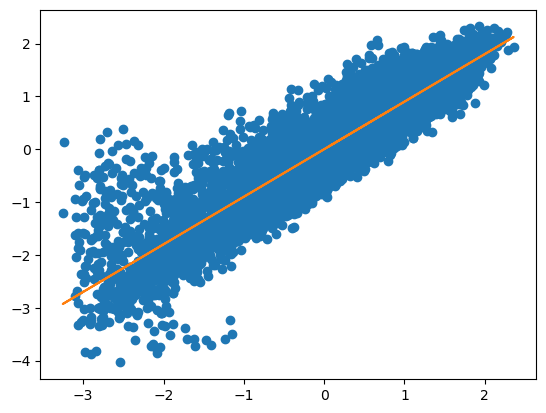

In [ ]:
plt.scatter(x_training, y_training, label="Data Points")
plt.plot(x_training,modelLinear.predict(x_training),'C1')

Ahora nos encontramos con una problematica planteada en el articulo Reconstructing long‑term wind speed data based on measure correlate predict method for micro‑grid planning, donde se nos dice que este acercamiento a los datos puede tener un subajuste, además de plantearse la problemática de realizar este tipo de caracterizaciones teniendo estaciones con muy baja correlación. por esto mismo vamos a realizar la implementación de el articulo previamente mencionado.


<h3>Replicación paper: Reconstructing long‑term wind speed data based on measure 
correlate predict method for micro‑grid planning</h3>
se van a usar datos del 2011 de un aeropuerto de Colombia y los de Reanalisis del ERA

el plan de accion sería el siguiente:
<ol>
<li>se define año y coordenadas para la realización del MCP.</li>
<li>tener un data frame de referencia que cargamos con los métodos previamente planteados, los datos serían del ERA.</li>
<li>tener un data frame objetivo, este se crea a partir de los datos de las estaciones de IDEAM.</li>
<li>se realizan las tranformaciones necesarias de los datos para poder realizar una correlación entre ellos,</br> además de usarse en el CRP y al momento de entrenar modelos.</li>
<li>se realiza el metodo de CRP para confirmar la relación de los datos.</li>
<li>se realizan ls RBFNN para lograr una caracterización de la ubicación objetivo.</li>
<li>se realizan algoritmos geneticos para optimizar este método.</li>
<li>se plantea la experimentacion con otras redes: LSTM, RNN y demás métodos de forecasting.</li>
<li>se optimizan los métodos con mejores scores utilizando algoritmos genéticos y grid search.</li>




</ol>

In [ ]:
# consiguiendo las coordenadas de los lugares por analisar, los datos disponibles
df = pd.read_csv('target_data/sgfv-3yp8.csv')
df.head()

,codigoestacion,codigosensor,fechaobservacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud,descripcionsensor,unidadmedida
0,2612500130,103,2020-06-03T16:30:00.000,0.60,SALENTO - AUT,QUINDÍO,SALENTO,CAUCA,4.633475,-75.568858,Velocidad Viento (10 min),m/s
1,23190130,103,2020-06-03T15:40:00.000,1.20,TONA - AUT,SANTANDER,TONA,MEDIO MAGDALENA,7.196111,-72.970556,Velocidad Viento (10 min),m/s
2,37045010,103,2020-06-03T15:20:00.000,2.00,SARAVENA - AUT,ARAUCA,SARAVENA,ARAUCA,6.946389,-71.890556,Velocidad Viento (10 min),m/s
3,21205710,103,2020-06-03T15:40:00.000,0.70,JARDIN BOTANICO - AUT,BOGOTA,"BOGOTA, D.C",ALTO MAGDALENA,4.669333,-74.102667,Velocidad Viento (10 min),m/s
4,21205527,103,2020-06-03T11:30:00.000,2.45,ALTO DEL AIRE - AUT,CUNDINAMARCA,CUCUNUBÁ,ALTO MAGDALENA,5.198000,-73.805000,Velocidad Viento (10 min),m/s


In [ ]:
# consiguiendo codigo de la estacion del aeropuerto
df[df['municipio']=='MEDELLÍN'].head()

,codigoestacion,codigosensor,fechaobservacion,valorobservado,nombreestacion,departamento,municipio,zonahidrografica,latitud,longitud,descripcionsensor,unidadmedida
185,27015330,103,2020-06-03T09:00:00.000,1.1,APTO OLAYA HERRERA - TX GPRS,ANTIOQUIA,MEDELLÍN,NECHÍ,6.221,-75.589,Velocidad Viento (10 min),m/s
270,27015330,103,2020-06-03T17:40:00.000,1.9,APTO OLAYA HERRERA - TX GPRS,ANTIOQUIA,MEDELLÍN,NECHÍ,6.221,-75.589,Velocidad Viento (10 min),m/s
377,27015330,103,2020-06-03T05:20:00.000,1.0,APTO OLAYA HERRERA - TX GPRS,ANTIOQUIA,MEDELLÍN,NECHÍ,6.221,-75.589,Velocidad Viento (10 min),m/s
645,27015330,103,2020-06-03T03:40:00.000,1.6,APTO OLAYA HERRERA - TX GPRS,ANTIOQUIA,MEDELLÍN,NECHÍ,6.221,-75.589,Velocidad Viento (10 min),m/s


In [ ]:
# coordenadas aeropuerto medellin
# 

lat = 6.221
long  =-75.589

In [ ]:
df_target = pd.read_csv("target_data/0027015330.data",sep = "\t")
df_target.head()

,fecha,velocidad
0,2014-12-03 15:30:00,0.4
1,2014-12-03 15:40:00,0.3
2,2014-12-03 15:50:00,0.4
3,2014-12-03 16:00:00,0.4
4,2014-12-03 16:10:00,0.3


In [ ]:
# conversion de los datos
df_target['fecha'] = pd.to_datetime(df_target['fecha'])

In [ ]:
# consiguiendo los datos del 2015 del aeropuerto olaya herrera
df_target = df_target[(df_target.fecha>'2015') & (df_target.fecha<'2016') ]

In [ ]:

year = 2015

df_reference = get_data_by_coordenates_date(lat, long,str(year),str(year+1))

/tmp/ipykernel_96766/3433687123.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acum = xr.open_dataset(df_filtered['link'][0]).sel(


In [ ]:
df_reference
true_100_false_10 = True
# se decide si se quieren datos a 100 m o 10 m de altura
df_reference = pd.DataFrame(np.hypot(df_reference['u100' if true_100_false_10 else 'u10'],df_reference['v100' if true_100_false_10 else 'v10']))

In [ ]:
df_reference

,0
valid_time,
2015-01-01 00:00:00,2.006806
2015-01-01 01:00:00,1.791918
2015-01-01 02:00:00,1.492093
2015-01-01 03:00:00,1.145472
2015-01-01 04:00:00,1.344328
...,...
2015-12-31 19:00:00,3.115741
2015-12-31 20:00:00,2.665072
2015-12-31 21:00:00,2.155608


In [ ]:
df_target.index = df_target.fecha
df_target = df_target.drop('fecha',axis = 1)